# Project: Multiclass Emotions Detection using BERT

This project aims to classify text using BERT (Bidirectional Encoder Representations from Transformers) in Tensorflow Keras. The dataset [Emotion Detection from Text](https://www.kaggle.com/pashupatigupta/emotion-detection-from-text/code) is downloaded from Kaggle.

### Install required libraries

In [1]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install sklearn
#!pip install tensorflow
#!pip install transformers
#!pip install nltk

### Import the required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import warnings
warnings.simplefilter("ignore")

### Read and Inspect the Data

In [3]:
ed = pd.read_csv('tweet_emotions.csv')

In [4]:
ed.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [5]:
ed.shape

(40000, 3)

In [6]:
ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


There are 40000 rows and 3 columns in the dataset. For text classification, we are interested in the content and sentiment column.

### Exploratory Data Analysis

From insection, we see there is no missing value in the dataset. Let's check for the duplicate values.

In [7]:
ed.duplicated().sum()

0

There are no duplicates and there can't be outliers since both are text columns.

In [8]:
ed1 = ed.copy() #make a seperate copy of the original dataframe

In [9]:
#Check for the unique values in the sentiment column
ed1.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [10]:
ed1.sentiment.nunique()

13

In [11]:
#check random tweet from content series
ed1.content[3]

'wants to hang out with friends SOON!'

In [12]:
ed1.sentiment[3]

'enthusiasm'

#### Preprocess the sentiment column

In [13]:
ed1.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='count', ylabel='sentiment'>

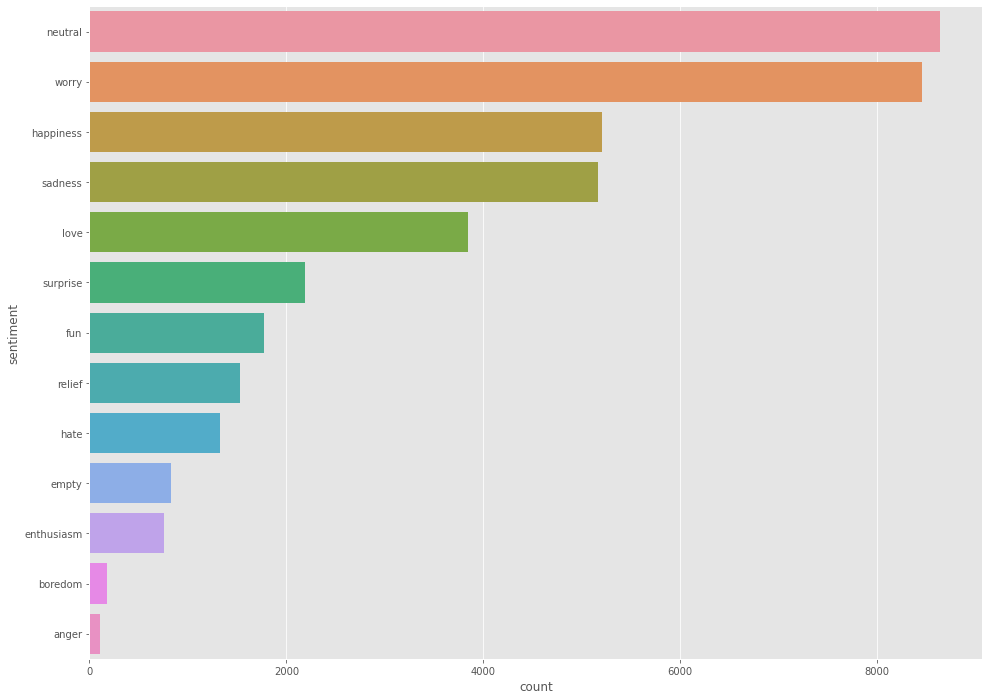

In [14]:
plt.figure(figsize = (16,12))
sns.countplot(y=ed1.sentiment,data = ed1,order =ed1.sentiment.value_counts().index)

Let's group together hate and anger under the label hate/anger and empty and boredom under the label empty/boredom.

In [15]:
def labels(sentiment):
    if sentiment=='hate' or sentiment == 'anger':
        return 'hate/anger'
    elif sentiment == 'empty' or sentiment ==  'boredom':
        return 'empty/boredom'
    else:
        return sentiment

ed1['sentiment'] = ed1.apply(lambda x: labels(x['sentiment']),axis=1)

In [16]:
ed1.sentiment.value_counts()

neutral          8638
worry            8459
happiness        5209
sadness          5165
love             3842
surprise         2187
fun              1776
relief           1526
hate/anger       1433
empty/boredom    1006
enthusiasm        759
Name: sentiment, dtype: int64

Convert the sentiments into labels so we can later on feed it to our neural network.

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [18]:
ed1["label"]= label_encoder.fit_transform(ed1.sentiment)
ed1.label

0        0
1        8
2        8
3        1
4        6
        ..
39995    6
39996    5
39997    5
39998    3
39999    5
Name: label, Length: 40000, dtype: int32

In [19]:
ed1.label.unique()

array([ 0,  8,  1,  6, 10,  9,  5,  2,  4,  3,  7])

In [20]:
ed1.head()

,tweet_id,sentiment,content,label
0,1956967341,empty/boredom,@tiffanylue i know i was listenin to bad habi...,0
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,8
2,1956967696,sadness,Funeral ceremony...gloomy friday...,8
3,1956967789,enthusiasm,wants to hang out with friends SOON!,1
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,6


#### Preprocesss the content column

In [21]:
#check random tweet from content series
ed1.content[99]

"@ cayogial i wanted to come to BZ this summer :/ not so sure anymore... a teacher's life in the summer SUCKS"

In [22]:
ed1.sentiment[99]

'hate/anger'

Let's tokenize our text to remove punctuation marks and also produce word tokens

In [23]:
word_tokenizer = nltk.RegexpTokenizer(r"\w+")
ed1.content = ed1.content.str.lower().apply(word_tokenizer.tokenize)

In [24]:
ed1.content[99]

['cayogial',
 'i',
 'wanted',
 'to',
 'come',
 'to',
 'bz',
 'this',
 'summer',
 'not',
 'so',
 'sure',
 'anymore',
 'a',
 'teacher',
 's',
 'life',
 'in',
 'the',
 'summer',
 'sucks']

Time to reduce the words into Lemmas by using wordnet lemmatizer and remove stopwords.

In [25]:
#nltk.download('wordnet')

In [26]:
from nltk.stem import WordNetLemmatizer 
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
    
ed1.content = ed1.content.apply(lemmatize_text)

In [27]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
ed1.content=ed1.content.apply(lambda x: [item for item in x if item not in stop])

In [28]:
ed1.content[99]

['cayogial',
 'wanted',
 'come',
 'bz',
 'summer',
 'sure',
 'anymore',
 'teacher',
 'life',
 'summer',
 'suck']

In [29]:
ed1.content

0        [tiffanylue, know, wa, listenin, bad, habit, e...
1          [layin, n, bed, headache, ughhhh, waitin, call]
2                      [funeral, ceremony, gloomy, friday]
3                               [want, hang, friend, soon]
4        [dannycastillo, want, trade, someone, ha, hous...
                               ...                        
39995                                    [johnlloydtaylor]
39996                           [happy, mother, day, love]
39997    [happy, mother, day, mommy, woman, man, long, ...
39998    [niariley, wassup, beautiful, follow, peep, ne...
39999    [mopedronin, bullet, train, tokyo, gf, visitin...
Name: content, Length: 40000, dtype: object

They are in shape of list. Let's remove the brackets from both sides of the text.

In [30]:
ed1.content= ed1.content.apply(lambda x: str(x).replace(',','').lstrip('[').rstrip(']')).str.replace("'","")

In [31]:
ed1.content[99]

'cayogial wanted come bz summer sure anymore teacher life summer suck'

In [32]:
ed1.head()

,tweet_id,sentiment,content,label
0,1956967341,empty/boredom,tiffanylue know wa listenin bad habit earlier ...,0
1,1956967666,sadness,layin n bed headache ughhhh waitin call,8
2,1956967696,sadness,funeral ceremony gloomy friday,8
3,1956967789,enthusiasm,want hang friend soon,1
4,1956968416,neutral,dannycastillo want trade someone ha houston ti...,6


In [33]:
ed2 = ed1.copy()

Our EDA and data preprocessing is done here. 

### Split into Training and Test dataset

In [34]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(\
    ed2.content,ed2.label,test_size = 0.3,stratify = ed2.label)

In [37]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(28000,) (28000,) (12000,) (12000,)


In [38]:
X_train.head()

8910                              still office sun shining
17359                                          acaaaaaabou
30             annoying start typing computer middle night
1511     awoke completely freaked frantic frenzy going ...
25313                                             wa worth
Name: content, dtype: object

In [39]:
y_train.head()

8910     8
17359    6
30       4
1511     8
25313    7
Name: label, dtype: int32

In [40]:
#Converting labels into one hot enocders
from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train)
y_test_onehot= to_categorical(y_test)

In [41]:
y_train_onehot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [42]:
y_test_onehot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

#### Import Bert PreProcessor and Bert Encoder

In [45]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### Preparing the Model 

In [56]:
max_len = 70

In [57]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length = max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [58]:
x_test = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length = max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

####  Build the Model

In [59]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

Keras has two type of model functions, sequential and functional. Here we are using functional model.

In [60]:
#Input layers
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

#Bert Embedded layer
embeddings = bert(input_ids,attention_mask = input_mask)[0] 

#NeuralNetwork Layers
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(64, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
#output layer
y = Dense(11,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [61]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    multiple             108310272   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 768)         0           ['tf_bert_model[1][0]']    

In [62]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy("categorical_accuracy"),

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

#### Train the model

In [63]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train_onehot,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test_onehot
    ),
  epochs=1
)

875/875 [==============================] - ETA: 0s - loss: 1.9453 - categorical_accuracy: 0.3255 

ValueError: in user code:

    File "C:\Users\Lenovo\anaconda3\envs\emotions\lib\site-packages\keras\engine\training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\Lenovo\anaconda3\envs\emotions\lib\site-packages\keras\engine\training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Lenovo\anaconda3\envs\emotions\lib\site-packages\keras\engine\training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\Lenovo\anaconda3\envs\emotions\lib\site-packages\keras\engine\training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\Lenovo\anaconda3\envs\emotions\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Lenovo\anaconda3\envs\emotions\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 70), found shape=(32, 65)


#### Evaluate the Model

In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

In [ ]:
y_predicted = np.argmax(predicted_raw, axis = 1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predicted)

In [ ]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')